# Yolo与深度图

导入库函数

In [1]:
import sys
import os, platform
import json
import numpy as np
import cv2
import ctypes

from PIL import Image
from datetime import datetime

from pynq.lib.video import *
from pynq.overlays.base import BaseOverlay

import qnn
from qnn import TinierYolo
from qnn import utils 
sys.path.append("/opt/darknet/python/")
from darknet import *

from matplotlib import pyplot as plt
%matplotlib inline

## 1. 初始化分类器

In [2]:
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-W.npy', encoding="latin1", allow_pickle=True)
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-W.npy', encoding="latin1", allow_pickle=True)
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-bias.npy', encoding="latin1", allow_pickle=True)
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:,np.newaxis], (net['conv1']['input'][0],net['conv1']['input'][1]*net['conv1']['input'][1]))
conv8_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-bias.npy', encoding="latin1", allow_pickle=True)
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:,np.newaxis], (125,13*13))
file_name_cfg = c_char_p("/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = lib.parse_network_cfg(file_name_cfg)

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


## 2. 标定摄像头与深度图

选定主体打印距离函数

In [3]:
def print_location(image):
    global nr
    global nc
   # nr = image.shape[0]
   # nc = image.shape[1]
   # flag[:,:]
    nr = len(image)
    nc = len(image[0])
    font=cv2.FONT_HERSHEY_SIMPLEX
    for i in range(3,int(nr/10)-2):
        for j in range(3,int((nc-1)/10)-3):
            if int(image[i*10,j*10]-image[i*10,(j+3)*10])>100 and image[i*10,(j+3)*10] ==0 and image[i*10,j*10]> 10 and int(image[i*10,j*10] - image[(i-3)*10,j*10]) > 100 and image[(i-3)*10,j*10]==0 and  (image[i*10,j*10]-image[i*10,(j-3)*10])>100 and image[i*10,(j-3)*10] ==0 and (image[i*10,j*10] - image[(i+2)*10,j*10]) > 100 : 
            #and image[i*10,j*10]<250 and image[i*10,j*10]>10:
                print(threeD[i*10][j*10][2])
                cv2.putText(img1_rectified,str(threeD[i*10][j*10][2]),(i*10,j*10), font, 0.5,(255,0,0),2)
  #  print("\n")
               

In [75]:
def print_location2(image,l,r,t,b):
    count=0
    num=0
    font=cv2.FONT_HERSHEY_SIMPLEX
    for i in range(int(t/10)+3,int((b-1)/10)-3):
        for j in range(int(l/10)+3,int(r/10)-2):
            if int(image[i*10,j*10]-image[i*10,(j+3)*10])>100 and image[i*10,(j+3)*10] ==0 and image[i*10,j*10]> 10 and int(image[i*10,j*10] - image[(i-3)*10,j*10]) > 100 and image[(i-3)*10,j*10]==0 and  (image[i*10,j*10]-image[i*10,(j-3)*10])>100 and image[i*10,(j-3)*10] ==0 and (image[i*10,j*10] - image[(i+2)*10,j*10]) > 100 : 
            #and image[i*10,j*10]<250 and image[i*10,j*10]>10:
                count=count+1
                num=num+threeD[i*10][j*10][2]
                print(threeD[i*10][j*10][2])
 #               cv2.putText(img1_rectified,str(threeD[i*10][j*10][2]),(i*10,j*10), font, 0.5,(255,0,0),2)
                break
    cv2.putText(imgd,str(round(num/count/1000,4))+'m',(int((l+r)/2),int((t+b)/2)), font, 0.8,(255,0,0),2)

摄像头设定和初始化

In [5]:
# camera (input) configuration
frame_in_w = 1280
frame_in_h = 480
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("Capture device is open: " + str(videoIn.isOpened()))


Capture device is open: True


摄像头标定参数导入

In [44]:
right_camera_matrix = np.array([[970.442193175645, 0.662149120351574,447.385660951263],
                               [0, 999.526759034729,319.300319578679],
                               [0, 0, 1]])
right_distortion = np.array([[-0.393721056519224,-1.02362248626099,-0.0224780874816298,-0.0215989661904819,4.08552046615739]])
 
#左摄像头参数
left_camera_matrix = np.array([[973.453231048070, 5.89303592282359, 445.920724405380],
                                [0, 995.574759198988, 317.679734843106],
                                [0, 0, 1]])
left_distortion = np.array([[-0.448699357794973,-0.0849339675189154,-0.0225275384276436,-0.0207099739316165, 0.196909016690212]])
 
#om = np.array([0.00456, 0.01463, 0.00042])        # 旋转关系向量
R = np.array([[0.999950836750182,-0.00214232390047800,-0.00968165951255393],
                                [0.00222247923459049,0.999963284118255,0.00827592904065060],
                                [0.00966357432130572,-0.00829703945630673,0.999918883943891]])                         # 使用Rodrigues变换将om变换为R
T = np.array([-57.5773465003307, 0.275555865411103,-9.17672718122313])      # 平移关系向量
 
size = (640, 480) # 图像尺寸
 
# 进行立体更正
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(left_camera_matrix, left_distortion,
                                                                  right_camera_matrix, right_distortion, size, R,
                                                                  T)
# 计算更正map
left_map1, left_map2 = cv2.initUndistortRectifyMap(left_camera_matrix, left_distortion, R1, P1, size, cv2.CV_16SC2)
right_map1, right_map2 = cv2.initUndistortRectifyMap(right_camera_matrix, right_distortion, R2, P2, size, cv2.CV_16SC2)

清缓存

In [45]:
for i in range(20):
    ret1, frame = videoIn.read()

图像读取与深度检测

In [46]:
ret1, frame = videoIn.read()
#frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame1 = frame[0:480,0:640]
frame2 = frame[0:480,640:1280]
 # 根据更正map对图片进行重构
img1_rectified = cv2.remap(frame1,left_map1, left_map2, cv2.INTER_LINEAR)
img2_rectified = cv2.remap(frame2,right_map1, right_map2, cv2.INTER_LINEAR)
imgL = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)
window_size = 5
stereo = cv2.StereoSGBM_create(
minDisparity=0,
numDisparities=10*16,  # max_disp has to be dividable by 16 f. E. HH 192, 256
blockSize=7,
P1=8 * 3 * window_size ** 2,
# wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
P2=32 * 3 * window_size ** 2,
disp12MaxDiff=10,
uniquenessRatio=10,
speckleWindowSize=70,
speckleRange=2,
preFilterCap=63,
mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
disparity = stereo.compute(imgL, imgR)
disp = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
threeD = cv2.reprojectImageTo3D(disparity.astype(np.float32)/16., Q)
#cv2.imwrite('./yoloimages/video.jpg',img1_rectified)
#print_location(disp)
cv2.imwrite('./yoloimages/video.jpg',img1_rectified)

True

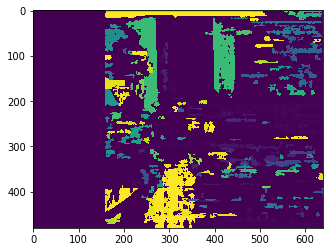

In [48]:
plt.imshow(disp)
plt.show()

读取储存的图片，准备开始yolo

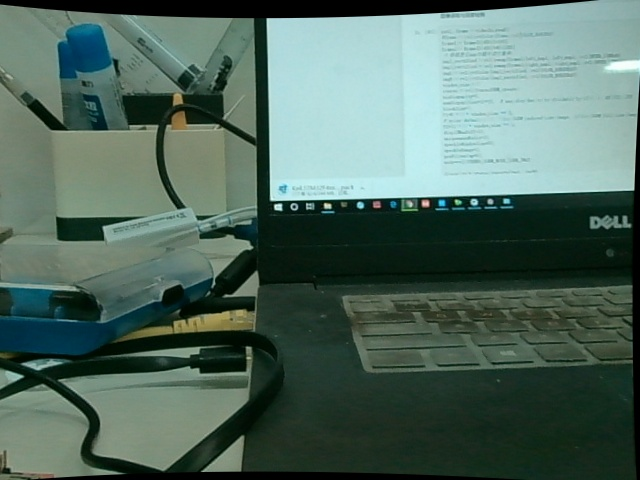

In [47]:
img_folder = './yoloimages/'
img_file = os.path.join(img_folder, 'video.jpg')
file_name = c_char_p(img_file.encode())
#_ , cv2_im = videoIn.read()
#cv2_im = cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
#cv2_im = cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
#img = Image.fromarray(cv2_im)
img = load_image(file_name,0,0)
img_letterbox = letterbox_image(img,416,416)
img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
img_copy = np.swapaxes(img_copy, 0,2)
free_image(img)
free_image(img_letterbox)

im = Image.open(img_file)
im

## 3. Yolo卷积

In [49]:
start = datetime.now()
img_copy = img_copy[np.newaxis, :, :, :]
    
conv0_ouput = utils.conv_layer(img_copy,conv0_weights_correct,b=conv0_bias_broadcast,stride=2,padding=1)
conv0_output_quant = conv0_ouput.clip(0.0,4.0)
conv0_output_quant = utils.quantize(conv0_output_quant/4,3)
end = datetime.now()
#micros = int((end - start).total_seconds() * 1000000)

out_dim = net['conv7']['output'][1]
out_ch = net['conv7']['output'][0]

conv_output = classifier.get_accel_buffer(out_ch, out_dim)
conv_input = classifier.prepare_buffer(conv0_output_quant*7);

start = datetime.now()
classifier.inference(conv_input, conv_output)
end = datetime.now()

conv7_out = classifier.postprocess_buffer(conv_output)
#help(conv7_out)
isinstance(conv7_out, np.ndarray)

#micros = int((end - start).total_seconds() * 1000000)

start = datetime.now()
conv7_out_reshaped = conv7_out.reshape(out_dim,out_dim,out_ch)
out_dim
conv7_out_swapped = np.swapaxes(conv7_out_reshaped, 0, 1) # exp 1
conv7_out_swapped
conv7_out_swapped = conv7_out_swapped[np.newaxis, :, :, :] 

conv8_output = utils.conv_layer(conv7_out_swapped,conv8_weights_correct,b=conv8_bias_broadcast,stride=1)  
conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

end = datetime.now()
#micros = int((end - start).total_seconds() * 1000000)

## 4. 图形标注

In [50]:
lib.forward_region_layer_pointer_nolayer(net_darknet,conv8_out)
tresh = c_float(0.3)
tresh_hier = c_float(0.5)
file_name_out = c_char_p("/home/xilinx/jupyter_notebooks/qnn/detection".encode())
file_name_probs = c_char_p("/home/xilinx/jupyter_notebooks/qnn/probabilities.txt".encode())
file_names_voc = c_char_p("/opt/darknet/data/voc.names".encode())
darknet_path = c_char_p("/opt/darknet/".encode())
lib.draw_detection_python(net_darknet, file_name, tresh, tresh_hier,file_names_voc, darknet_path, file_name_out, file_name_probs);

#Print probabilities
file_content = open(file_name_probs.value,"r").read().splitlines()
detections = []
for line in file_content[0:]:
    name, probability = line.split(": ")
    detections.append((probability, name))
for det in sorted(detections, key=lambda tup: tup[0], reverse=True):
    print("class: {}\tprobability: {}".format(det[1], det[0]))


class: car	probability: 95%
class: tvmonitor	probability: 55%


yolo的Bounding-Box坐标读取

In [76]:
aa = []
bb=[[],[],[],[],[]]
count=0
f = open('video2.txt', 'r')
for line in f.readlines():
    if line.split():
        aa.append(line.split())
        count=count+1
#print(aa)
for i in range(len(aa)):
    for j in range(len(aa[i])):
            bb[i].append(int(aa[i][j]))
#print(bb)
imgd=cv2.imread('detection.png')
for i in range(count):
    print_location2(disp,bb[i][0],bb[i][1],bb[i][2],bb[i][3])
cv2.imwrite('result.png',imgd)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


699.25
640.98
338.631
769.175
353.354
632.508
620.66
482.62
858.9
358.65
666.778
467.685
496.815
342.535
574.318
690.286
684.799
583.656
356.571
365.963
617.989


True

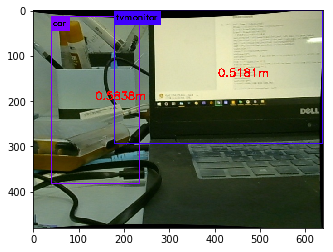

In [77]:
plt.imshow(imgd)
plt.show()

## 7. 展示结果

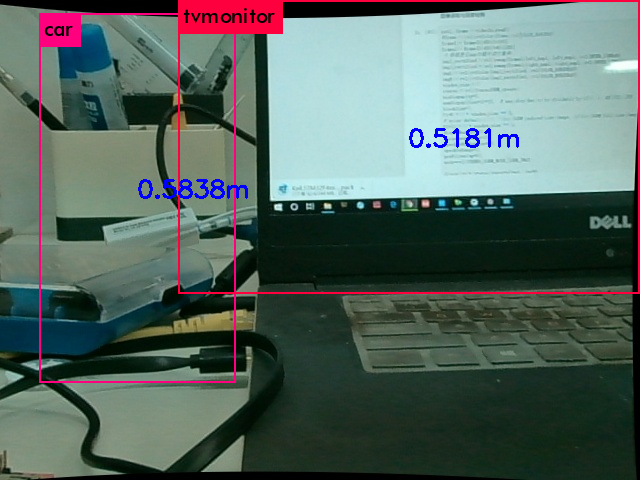

In [78]:
res = Image.open('result' + ".png")
res

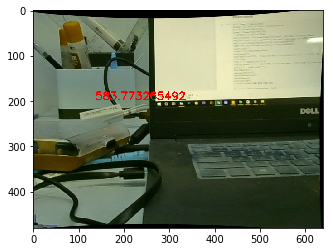

In [79]:
plt.imshow(img1_rectified)
plt.show()

## 关闭设备

In [12]:
classifier.deinit_accelerator()

In [54]:
videoIn.release()

In [13]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()